In [1]:
# 引入库
import torch
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
# 超参数
epochs = 10
batch_size = 64
learning_rate = 1e-3

In [3]:
# 数据准备
data = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

ds_train = datasets.MNIST("./data", train=True, transform=data, download=True)
ds_test = datasets.MNIST("./data", train=False, transform=data)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


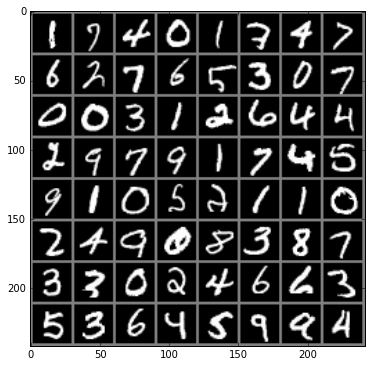

In [4]:
# 数据预览
images, labels = next(iter(train_loader))
image = torchvision.utils.make_grid(images)
image = image.numpy().transpose(1,2,0)
std = mean = [0.5, 0.5, 0.5]
image = image * std + mean

plt.figure(figsize=(6, 8))
plt.imshow(image)
plt.show()

In [6]:
# 设置训练使用的设备类型 GPU or CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# 构建CNN模型
# 建立3个卷积层网络、2个池化层、1个全连接层
# 第一层网络中，包含卷积层和池化层。将1*28*28的图片卷积成32*26*26，并且池化成32*13*13
# 第二层网络中，包含卷积层和池化层。将32*13*13的图片卷积成64*11*11，并且池化成64*5*5
# 第三层网络中，为卷积层，将64*5*5的图片转换成64*3*3
# 第四次网络为全连接网络

class Alex_Net(nn.Module):
    def __init__(self):
        super(Alex_Net,self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True))
        
        self.dense = nn.Sequential(
            nn.Linear(576, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),
            nn.Softmax())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) 
        # x = x.view(x.size(0), -1) # Flatten 展开
        x = self.flatten(x)        # Flatten 展开
        x = self.dense(x)
        return x

model = Alex_Net().to(device)     # 创建模型
print(model)             # 输出模型结构

Using cuda device
Alex_Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dense): Sequential(
    (0): Linear(in_features=576, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): Softmax(dim=None)
  )
)


In [7]:
def train(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error (前向传播)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation  (反向传播)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics (计算指标)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # 每隔100批次输出当前进度
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    correct /= size
    history["train_loss"] = history.get("train_loss", []) + [train_loss]
    history["train_accuracy"] = history.get("train_accuracy", []) + [100*correct]
    print(f"train_loss: {train_loss:>7f}, train_accuracy: {(100*correct):>0.3f}%,", end=" ")

In [8]:
def test(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    history["test_loss"] = history.get("test_loss", []) + [test_loss]
    history["test_accuracy"] = history.get("test_accuracy", []) + [100*correct]
    print(f"test_loss: {test_loss:>8f}, test_accuracy: {(100*correct):>0.3f}% \n")

In [9]:
history = {}
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, history)
    test(test_loader, model, loss_fn, history)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 2.303711  [    0/60000]
loss: 1.641603  [ 6400/60000]
loss: 1.648372  [12800/60000]
loss: 1.661905  [19200/60000]
loss: 1.575618  [25600/60000]
loss: 1.545944  [32000/60000]
loss: 1.496341  [38400/60000]
loss: 1.522942  [44800/60000]
loss: 1.500847  [51200/60000]
loss: 1.519886  [57600/60000]
train_loss: 1.586360, train_accuracy: 87.828%, test_loss: 1.486638, test_accuracy: 97.680% 

Epoch 2
-------------------------------
loss: 1.475539  [    0/60000]
loss: 1.499398  [ 6400/60000]
loss: 1.477083  [12800/60000]
loss: 1.496663  [19200/60000]
loss: 1.491859  [25600/60000]
loss: 1.469345  [32000/60000]
loss: 1.463840  [38400/60000]
loss: 1.476382  [44800/60000]
loss: 1.467058  [51200/60000]
loss: 1.462114  [57600/60000]
train_loss: 1.485451, train_accuracy: 97.643%, test_loss: 1.481370, test_accuracy: 98.010% 

Epoch 3
-------------------------------
loss: 1.490652  [    0/60000]
loss: 1.479692  [ 6400/60000]
loss: 1.470976  [12800/60000]
loss: 1.483524  [19200/60000]
loss: 1.492113

In [10]:
def plot_metric(history, metric, loc="upper right"):
    train_metrics = history['train_'+metric]
    test_metrics = history['test_'+metric]
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'b--')
    plt.plot(epochs, test_metrics, 'r-')
    plt.title('Training and test '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid(axis="y")
    plt.grid(axis="x")
    plt.legend(["train_"+metric, 'test_'+metric], loc=loc)
    plt.show()

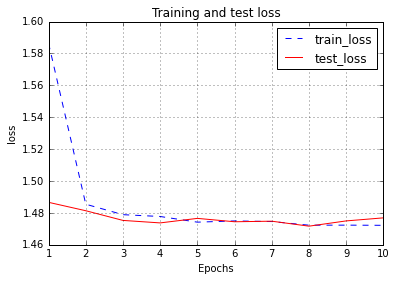

In [11]:
plot_metric(history, "loss")

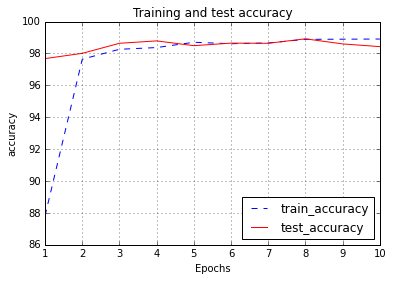

In [12]:
plot_metric(history, "accuracy", "lower right")

label:  7
pred label:  tensor(7, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


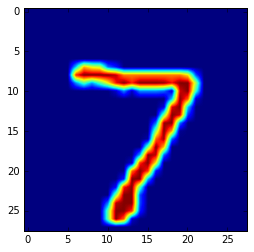

In [13]:
images, labels = next(iter(test_loader))
pred = model(images.to(device))

print("label: ", int(labels[0]))
print("pred label: ", pred.argmax(1)[0])
plt.imshow(images[0].reshape(28,28))